In [18]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.fillna(0, inplace=True)

In [5]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
df['median_house_value'] = np.log1p(df['median_house_value'])

In [11]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
y_train = df_train['median_house_value']
y_val = df_val['median_house_value']
y_test = df_test['median_house_value']

In [14]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [15]:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [16]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Question 1
Let's train a decision tree regressor to predict the median_house_value variable.
- Train a model with max_depth=1

Which feature is used for splitting the data?
- ocean_proximity=INLAND
- total_rooms
- latitude
- population

In [19]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [21]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



In [24]:
# Answer ocean_proximity=INLAND

# Question 2
Train a random forest model with these parameters:
- n_estimators=10
- random_state=1
- n_jobs=-1 (optional-to make training faster)

What's the RMSE of this model on validation?
- 0.05
- 0.25
- 0.55
- 0.85

In [25]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [26]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.2457383433183843

In [27]:
# Answer is 0.25

# Question 3
Now let's experiment with the n_estimators parameter
- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?
- 10
- 50
- 70
- 150

In [33]:
scores = []
for n in np.arange(10,201,10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    scores.append((n,np.sqrt(mean_squared_error(y_val, y_pred))))

In [36]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'rmse'])
df_scores.head()

,n_estimators,rmse
0,10,0.245738
1,20,0.239262
2,30,0.235717
3,40,0.234583
4,50,0.233104


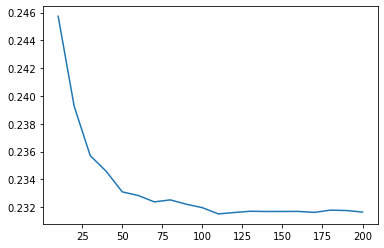

In [41]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

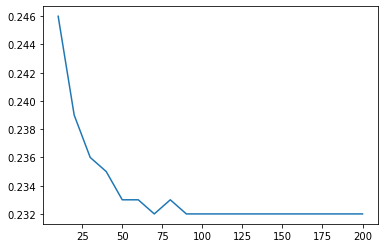

In [42]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [ ]:
# Answer is 70

# Question 4
Let's select the best max_depth:
- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

What's the best max_depth:
- 10
- 15
- 20
- 25

In [43]:
scores = []
max_depth = [10, 15, 20, 25]
for n_depth in max_depth:
    for n in np.arange(10,201,10):
        rf = RandomForestRegressor(max_depth = n, n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scores.append((n_depth,n, score))

In [44]:
df_scores = pd.DataFrame(scores, columns = ['max_depth', 'n_estimators', 'rmse'])
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,0.255042
1,10,20,0.238937
2,10,30,0.235623
3,10,40,0.234583
4,10,50,0.233104


In [46]:
df_scores[df_scores.rmse == df_scores.rmse.max()]

,max_depth,n_estimators,rmse
20,15,10,0.255042
60,25,10,0.255042


In [47]:
# Answer is either 15 or 25

# Question 5
